In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

# Dependencies

In [ ]:
# !pip install -U scipy (Don't think we need this)
# !pip install -q tflite-model-maker (Don't think we need this)

In [ ]:
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.signal import spectrogram
import librosa 
import librosa.display

import pandas as pd
import os
import numpy as np
from os.path import exists

import pathlib

import seaborn as sns
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from IPython import display

import shutil

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

from google.colab import files

In [ ]:
%tensorflow_version 2.1.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Group Data

## Getting Data

In [ ]:
# Add our recordings to the data directory
!git clone -q --depth 1 https://github.com/Dernibes/SpeakerRecognitionGroupProject.git
%cd SpeakerRecognitionGroupProject/TrainingDataGen
!pwd

/content/SpeakerRecognitionGroupProject/TrainingDataGen
/content/SpeakerRecognitionGroupProject/TrainingDataGen


In [ ]:
# Use this cell to configure/format github repo if necessary

In [ ]:
names = ["Seb", "Riccardo", "Adam", "Xixian", "Ibrahim"]
GROUP_DATA_DIR = "/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training"

# Creating train, val and test files
files = tf.io.gfile.glob(str(GROUP_DATA_DIR) + '/*/*')
num_samples = len(files)

# Shuffle data
files = tf.random.shuffle(files)

# Example format
example_file = tf.io.read_file(files[0])
example_audio, _ = tf.audio.decode_wav(contents=example_file)
print(example_audio.shape)
print(len(files))

(47040, 1)
340


## Splitting Data

In [ ]:
# Split into train, val and test sets
train_files = files[:int(num_samples*0.8)]
val_files = files[int(num_samples*0.8):int(num_samples*0.9)]
test_files = files[-int(num_samples*0.1):]

# Convert files to TensorSliceDataset
train_files_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_files_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_files_ds = tf.data.Dataset.from_tensor_slices(test_files)

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 272
Validation set size 34
Test set size 34


# Waveforms

## Preprocessing

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  print("audio = {}, audio shape = {}".format(audio, tf.shape(audio)))
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  # Return label of specified file
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  # return both the decoded waveform and the associated label
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE

# Convert files_ds to MapDataset
train_waveform_ds = train_files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

val_waveform_ds = val_files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

test_waveform_ds = test_files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

audio = Tensor("DecodeWav:0", shape=(None, None), dtype=float32), audio shape = Tensor("Shape:0", shape=(2,), dtype=int32)
audio = Tensor("DecodeWav:0", shape=(None, None), dtype=float32), audio shape = Tensor("Shape:0", shape=(2,), dtype=int32)
audio = Tensor("DecodeWav:0", shape=(None, None), dtype=float32), audio shape = Tensor("Shape:0", shape=(2,), dtype=int32)


## Visualising

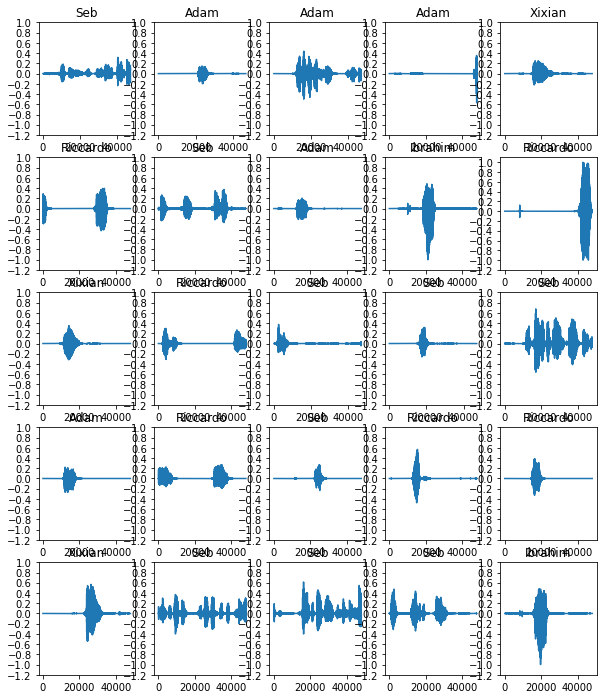

In [ ]:
# Plotting some waveforms
rows = 5
cols = 5 # I've played around with this 
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(train_waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Spectrogram

## Preprocessing

In [ ]:
def get_spectrogram(waveform):
  # Spectogram of a waveform
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  print("tf spectrogram: {}, tf spectrogram shape: {}".format(spectrogram, tf.shape(spectrogram)))
  spectrogram = tf.image.grayscale_to_rgb(spectrogram, name=None)
  return spectrogram

def get_spectrogram_and_label_id(audio, label):
  # Return spectogram and label
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == names)
  return spectrogram, label_id

In [ ]:
# Convert files_ds to MapDataset
train_ds = train_waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)

val_ds = val_waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)

test_ds = test_waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)

tf spectrogram: Tensor("strided_slice_1:0", shape=(None, 129, 1), dtype=float32), tf spectrogram shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)
tf spectrogram: Tensor("strided_slice_1:0", shape=(None, 129, 1), dtype=float32), tf spectrogram shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)
tf spectrogram: Tensor("strided_slice_1:0", shape=(None, 129, 1), dtype=float32), tf spectrogram shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)


## Augmentation

In [ ]:
# Choose whether to augment the data
augment_data = False

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(124, 129),
  layers.Rescaling(1./255)
])

if augment_data:
  train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

## Visualising

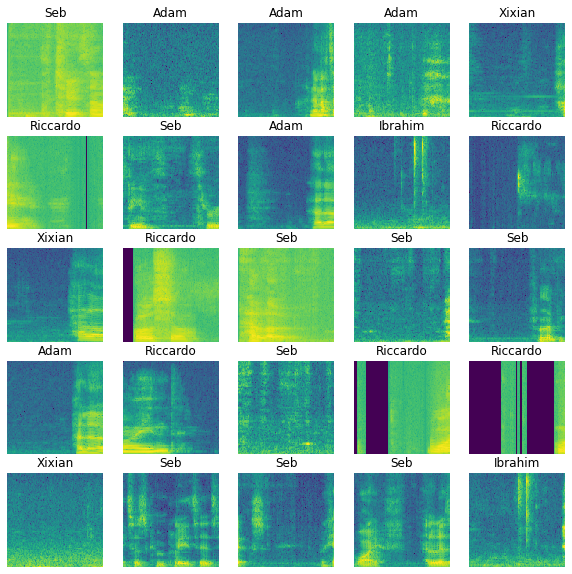

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Plotting a given spectogram
  if len(spectrogram.shape) > 2:
    spectrogram_1 = spectrogram[:, :, 0]
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram_1.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram_1), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# Plotting some Spectograms
rows = 5
cols = 5 #I've played around with the size of this
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(names[label_id.numpy()])
  ax.axis('off')

plt.show()

# Model

## Parameters

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Reduce latency
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(names)

Input shape: (64, 124, 129, 3)


## Definition

In [ ]:
# Choose "False" if you want to load ResNet50 Model
custom_model = True

# Choose "True" if you want to augment the data
data_augmentation = False

if custom_model:
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=((124,129,3))))
  if data_augmentation:
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomTranslation(0.1, 0.1))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(5, activation='softmax'))
  model._name = "custom"

else:
  model = models.Sequential()
  pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(124,129,3),
                    pooling='avg',classes=5,
                    weights='imagenet')
  for layer in pretrained_model.layers:
          layer.trainable=False
  model.add(pretrained_model)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  model._name = "ResNet50"

model.summary()

Model: "custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 122, 127, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 59, 61, 64)       256       
 hNormalization)                                                 
                                                            

## Compilation

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Training

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 12s 2s/step - loss: 3.1048 - accuracy: 0.4522 - val_loss: 1.5025 - val_accuracy: 0.3529
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 0.8993 - accuracy: 0.6728 - val_loss: 1.4786 - val_accuracy: 0.3235
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 0.4210 - accuracy: 0.8529 - val_loss: 1.4481 - val_accuracy: 0.4118
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 0.2544 - accuracy: 0.9301 - val_loss: 1.4463 - val_accuracy: 0.3824
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 0.1455 - accuracy: 0.9559 - val_loss: 1.4285 - val_accuracy: 0.3824
Epoch 6/10
5/5 [==============================] - 16s 3s/step - loss: 0.1075 - accuracy: 0.9669 - val_loss: 1.4389 - val_accuracy: 0.3529
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 0.0694 - accuracy: 0.9743 - val_loss: 1.4110 - val_accuracy: 0.4706
Epoch 8/10
5/5 [==============================] - 

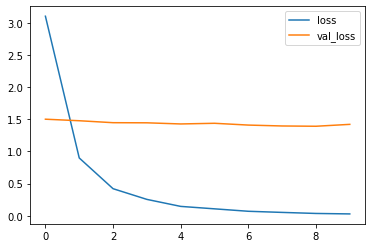

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Testing

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 56%


## Confusion Matrix

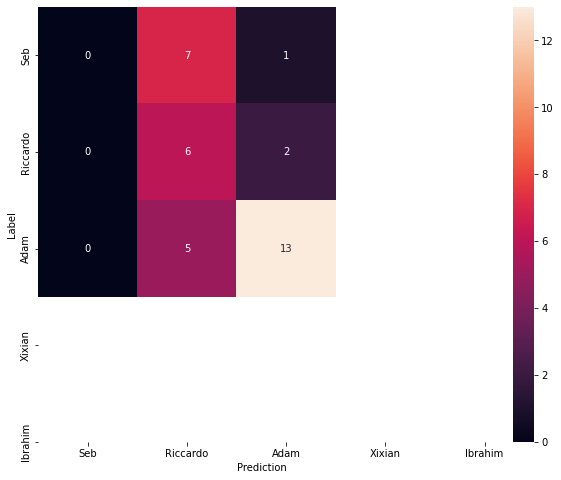

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=names,
            yticklabels=names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inference

audio = Tensor("DecodeWav:0", shape=(None, None), dtype=float32), audio shape = Tensor("Shape:0", shape=(2,), dtype=int32)
tf spectrogram: Tensor("strided_slice_1:0", shape=(None, 129, 1), dtype=float32), tf spectrogram shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)
tf.Tensor([[0.06627283 0.23337144 0.5029685  0.13115646 0.0662308 ]], shape=(1, 5), dtype=float32)


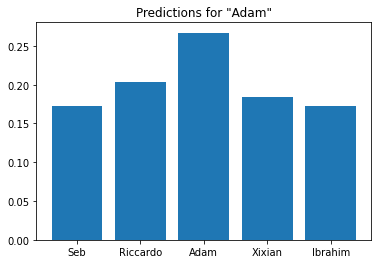

In [ ]:
### SPECIFIC FILE INFERENCE ###

# Choose a file to see model predictions!
sample_file = tf.io.gfile.glob(GROUP_DATA_DIR+ "/Adam/Adam_Hello_6.wav")

# Convert sample file to TensorSliceDataset
sample_file_ds = tf.data.Dataset.from_tensor_slices(sample_file)

# Convert sample_file_ds to MapDataset
sample_waveform_ds = sample_file_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

sample_ds = sample_waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  print(prediction)
  plt.bar(names, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{names[label[0]]}"')
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


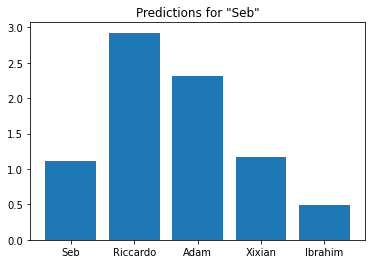

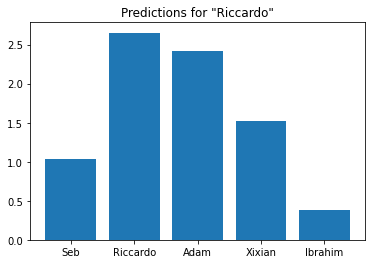

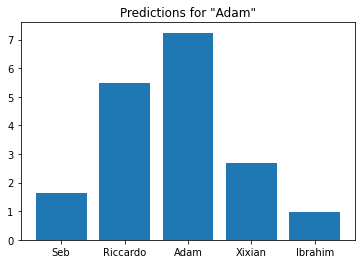

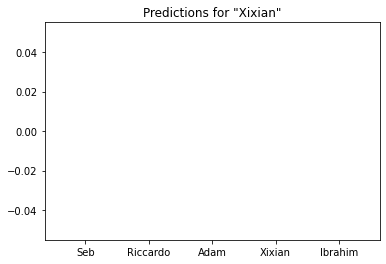

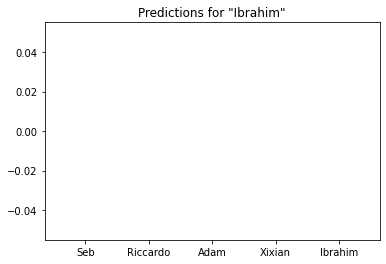

In [ ]:
### AVERAGE DATA INFERENCE ###

avgs = np.zeros((5,5))

for spectrogram, label in test_ds.batch(1):
  prediction = model(spectrogram)
  avgs[label] += prediction

avgs / len(test_files)

for i in range(len(names)):
  plt.bar(names, avgs[i])
  plt.title(f'Predictions for "{names[i]}"')
  plt.show()

# Save model as h5

In [ ]:
model.save('/content/infer_model')

INFO:tensorflow:Assets written to: /content/infer_model/assets


In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
!zip -r /content/infer_model.zip /content/infer_model

  adding: content/infer_model/ (stored 0%)
  adding: content/infer_model/assets/ (stored 0%)
  adding: content/infer_model/saved_model.pb (deflated 89%)
  adding: content/infer_model/keras_metadata.pb (deflated 92%)
  adding: content/infer_model/variables/ (stored 0%)
  adding: content/infer_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/infer_model/variables/variables.index (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save model weights

In [ ]:
model.save_weights('/content/infer_model_weights')

# Convert to TFLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpnrwgp1z9/assets


# Saving TFLite Model

In [ ]:
# Save the model.
with open('/content/model.tflite', 'wb') as f:
  f.write(tflite_model)

# VoicePrint Model

## Visualise infer model

In [ ]:
infer_model = load_model('/content/SpeakerRecognitionGroupProject/Voiceprint_model/voiceprint-regonition/models/infer_model.h5')

# Summarise model
infer_model.summary()

Model: "functional_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2_input (InputLaye  [(None, 257, 257, 1)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23558528  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 feature_output (Dense)      (None, 512)               1049088   
                                                                 
Total params: 24,615,808
Trainable params: 24,566,272
Non-trainable params: 49,536
_________________________________________________________________


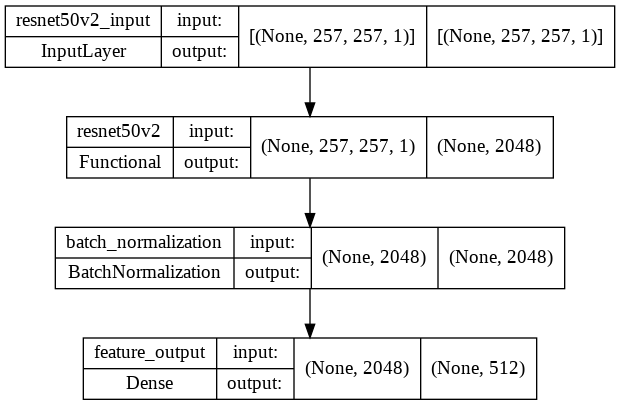

In [ ]:
# Visualising model
plot_model(infer_model, to_file='/content/infer_model_plot.png', show_shapes=True, show_layer_names=True)

## Visualise tflite infer model

In [ ]:
TFLITE_MODEL = '/content/SpeakerRecognitionGroupProject/Voiceprint_model/voiceprint-regonition/models/layers_model.tflite'
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_resnet50v2_input:0
shape: [  1 257 257   1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [   1 2048]
type: <class 'numpy.float32'>


## Optimization 

In [ ]:
# Choose a file to see model predictions!
sample_file = tf.io.gfile.glob(GROUP_DATA_DIR+ "/Adam/Adam_Hello_6.wav")

# Convert sample file to TensorSliceDataset
sample_file_ds = tf.data.Dataset.from_tensor_slices(sample_file)

# Convert sample_file_ds to MapDataset
sample_waveform_ds = sample_file_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

sample_ds = sample_waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram